# Multi-Class Model for Rice Varieties Identification Using TensorFlow Decision Forests
### David Lowe
### March 8, 2022

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: This project aims to construct a predictive model using various machine learning algorithms and document the end-to-end steps using a template. The Rice Varieties Identification dataset is a multi-class modeling situation where we attempt to predict one of several (more than two) possible outcomes.

INTRODUCTION: The dataset owner collected 75,000 pieces of rice grain and created a dataset that classifies the grains into one of the varieties (Arborio, Basmati, Ipsala, Jasmine, Karacadag). The research team applied various preprocessing operations to the rice images and obtained the features. Each record contains 106 attributes, including 12 morphological features, four shape features, and 90 color features obtained from five different color spaces (RGB, HSV, Lab*, YCbCr, XYZ).

ANALYSIS: The performance of the preliminary Gradient Boosted Trees model achieved an accuracy benchmark of 99.99% on the training dataset. When we applied the finalized model to the test dataset, the model achieved an accuracy score of 99.88%.

CONCLUSION: In this iteration, the TensorFlow Decision Forests model appeared to be a suitable algorithm for modeling this dataset.

Dataset Used: Rice MSC Dataset

Dataset ML Model: Multi-Class classification with numerical features

Dataset Reference: https://www.kaggle.com/mkoklu42/rice-msc-dataset

One source of potential performance benchmarks: https://www.kaggle.com/mkoklu42/rice-msc-dataset/code

## Task 1 - Prepare Environment

In [1]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 8


### 1.a) Load libraries and modules

In [2]:
# Set the random seed number for reproducible results
RNG_SEED = 888

In [3]:
import random
random.seed(RNG_SEED)
import numpy as np
np.random.seed(RNG_SEED)
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import math
from datetime import datetime
# import boto3
# from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.pipeline import Pipeline
from sklearn import compose
from sklearn import impute
from sklearn import metrics
import tensorflow as tf
tf.random.set_seed(RNG_SEED)
# from tensorflow import keras
import tensorflow_decision_forests as tfdf

### 1.b) Set up the controlling parameters and functions

In [4]:
# Begin the timer for the script processing
start_time_script = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
N_JOBS = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
NOTIFY_STATUS = False

# Set the percentage sizes for splitting the dataset
TEST_SET_RATIO = 0.2
VAL_SET_RATIO = 0.2

# Set the number of folds for cross validation
N_FOLDS = 5
N_ITERATIONS = 1

# Set various default modeling parameters
DEFAULT_METRICS = ["accuracy", tf.keras.metrics.SparseCategoricalCrossentropy()]

# Define the directory locations and file names
TRAIN_DATASET = 'Rice_MSC_Dataset.csv'
# TEST_DATASET = ''

# # Check the number of GPUs accessible through TensorFlow
# print('Num GPUs Available:', len(tf.config.list_physical_devices('GPU')))

# Print out the TensorFlow version for confirmation
print('TensorFlow version:', tf.__version__)

# Check the version of TensorFlow Decision Forests
print("Found TensorFlow Decision Forests v" + tfdf.__version__)

2022-03-06 15:35:30.251159: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:35:30.262331: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:35:30.263277: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


TensorFlow version: 2.8.0
Found TensorFlow Decision Forests v0.2.4


2022-03-06 15:35:30.265212: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-06 15:35:30.266012: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:35:30.266919: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-06 15:35:30.267751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [5]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [6]:
# Reset the random number generators
def reset_random(x=RNG_SEED):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [7]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [8]:
if not os.path.exists(TRAIN_DATASET):
    !wget https://dainesanalytics.com/datasets/kaggle-mkoklu42-rice-msc-dataset/Rice_MSC_Dataset.csv

In [9]:
df_dataset_import = pd.read_csv(TRAIN_DATASET, index_col=False)

# Take a peek at the dataframe after import
print(df_dataset_import.head())

   AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
0  7805    437.915    209.8215     48.0221        0.9735   99.6877    0.9775   
1  7503    340.757    138.3361     69.8417        0.8632   97.7400    0.9660   
2  5124    314.617    141.9803     46.5784        0.9447   80.7718    0.9721   
3  7990    437.085    201.4386     51.2245        0.9671  100.8622    0.9659   
4  7433    342.893    140.3350     68.3927        0.8732   97.2830    0.9831   

   CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  ALLdaub4L  ALLdaub4a  ALLdaub4b  \
0         7985  0.3547        4.3693  ...   113.9924    65.0610    59.5989   
1         7767  0.6637        1.9807  ...   105.7055    64.3685    62.2084   
2         5271  0.4760        3.0482  ...   109.7155    62.6423    58.7439   
3         8272  0.6274        3.9325  ...   116.5405    64.9069    60.2562   
4         7561  0.6006        2.0519  ...   107.7502    64.7071    61.3549   

   ALLdaub4Y  ALLdaub4Cb  ALLdaub4Cr  ALLdaub4XX  

In [10]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 107 columns):
 #    Column         Dtype  
---   ------         -----  
 0    AREA           int64  
 1    PERIMETER      float64
 2    MAJOR_AXIS     float64
 3    MINOR_AXIS     float64
 4    ECCENTRICITY   float64
 5    EQDIASQ        float64
 6    SOLIDITY       float64
 7    CONVEX_AREA    int64  
 8    EXTENT         float64
 9    ASPECT_RATIO   float64
 10   ROUNDNESS      float64
 11   COMPACTNESS    float64
 12   SHAPEFACTOR_1  float64
 13   SHAPEFACTOR_2  float64
 14   SHAPEFACTOR_3  float64
 15   SHAPEFACTOR_4  float64
 16   meanRR         float64
 17   meanRG         float64
 18   meanRB         float64
 19   StdDevRR       float64
 20   StdDevRG       float64
 21   StdDevRB       float64
 22   skewRR         float64
 23   skewRG         float64
 24   skewRB         float64
 25   kurtosisRR     float64
 26   kurtosisRG     float64
 27   kurtosisRB     float64
 28   entropyRR     

In [11]:
print(df_dataset_import.describe())

               AREA     PERIMETER    MAJOR_AXIS    MINOR_AXIS  ECCENTRICITY  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean    8379.197507    378.169453    161.805540     66.829335      0.886077   
std     3119.209274     70.597008     36.461005     16.689269      0.071906   
min     3929.000000    261.040000     96.968300     34.673000      0.627700   
25%     6259.000000    316.431500    132.623500     49.650200      0.846100   
50%     7345.000000    351.261000    149.343950     69.183900      0.885600   
75%     8901.000000    444.986000    197.462025     75.814125      0.950800   
max    21019.000000    593.698000    255.647200    113.441100      0.986800   

            EQDIASQ      SOLIDITY   CONVEX_AREA        EXTENT  ASPECT_RATIO  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean     101.731251      0.975896   8584.862320      0.633226      2.597063   
std       17.874070      0.007966   3189.298025    

In [12]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
CLASS           0
Length: 107, dtype: int64
Total number of NaN in the dataframe:  22


In [13]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('CLASS').size())

CLASS
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
dtype: int64


### 1.d) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
df_dataset_import = df_dataset_import.rename(columns={'CLASS': 'target'})

# Take a peek at the dataframe after cleaning
print(df_dataset_import.head())

   AREA  PERIMETER  MAJOR_AXIS  MINOR_AXIS  ECCENTRICITY   EQDIASQ  SOLIDITY  \
0  7805    437.915    209.8215     48.0221        0.9735   99.6877    0.9775   
1  7503    340.757    138.3361     69.8417        0.8632   97.7400    0.9660   
2  5124    314.617    141.9803     46.5784        0.9447   80.7718    0.9721   
3  7990    437.085    201.4386     51.2245        0.9671  100.8622    0.9659   
4  7433    342.893    140.3350     68.3927        0.8732   97.2830    0.9831   

   CONVEX_AREA  EXTENT  ASPECT_RATIO  ...  ALLdaub4L  ALLdaub4a  ALLdaub4b  \
0         7985  0.3547        4.3693  ...   113.9924    65.0610    59.5989   
1         7767  0.6637        1.9807  ...   105.7055    64.3685    62.2084   
2         5271  0.4760        3.0482  ...   109.7155    62.6423    58.7439   
3         8272  0.6274        3.9325  ...   116.5405    64.9069    60.2562   
4         7561  0.6006        2.0519  ...   107.7502    64.7071    61.3549   

   ALLdaub4Y  ALLdaub4Cb  ALLdaub4Cr  ALLdaub4XX  

In [15]:
df_dataset_import.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 107 columns):
 #    Column         Dtype  
---   ------         -----  
 0    AREA           int64  
 1    PERIMETER      float64
 2    MAJOR_AXIS     float64
 3    MINOR_AXIS     float64
 4    ECCENTRICITY   float64
 5    EQDIASQ        float64
 6    SOLIDITY       float64
 7    CONVEX_AREA    int64  
 8    EXTENT         float64
 9    ASPECT_RATIO   float64
 10   ROUNDNESS      float64
 11   COMPACTNESS    float64
 12   SHAPEFACTOR_1  float64
 13   SHAPEFACTOR_2  float64
 14   SHAPEFACTOR_3  float64
 15   SHAPEFACTOR_4  float64
 16   meanRR         float64
 17   meanRG         float64
 18   meanRB         float64
 19   StdDevRR       float64
 20   StdDevRG       float64
 21   StdDevRB       float64
 22   skewRR         float64
 23   skewRG         float64
 24   skewRB         float64
 25   kurtosisRR     float64
 26   kurtosisRG     float64
 27   kurtosisRB     float64
 28   entropyRR     

In [16]:
print(df_dataset_import.describe())

               AREA     PERIMETER    MAJOR_AXIS    MINOR_AXIS  ECCENTRICITY  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean    8379.197507    378.169453    161.805540     66.829335      0.886077   
std     3119.209274     70.597008     36.461005     16.689269      0.071906   
min     3929.000000    261.040000     96.968300     34.673000      0.627700   
25%     6259.000000    316.431500    132.623500     49.650200      0.846100   
50%     7345.000000    351.261000    149.343950     69.183900      0.885600   
75%     8901.000000    444.986000    197.462025     75.814125      0.950800   
max    21019.000000    593.698000    255.647200    113.441100      0.986800   

            EQDIASQ      SOLIDITY   CONVEX_AREA        EXTENT  ASPECT_RATIO  \
count  75000.000000  75000.000000  75000.000000  75000.000000  75000.000000   
mean     101.731251      0.975896   8584.862320      0.633226      2.597063   
std       17.874070      0.007966   3189.298025    

In [17]:
print(df_dataset_import.isnull().sum())
print('Total number of NaN in the dataframe: ', df_dataset_import.isnull().sum().sum())

AREA            0
PERIMETER       0
MAJOR_AXIS      0
MINOR_AXIS      0
ECCENTRICITY    0
               ..
ALLdaub4Cr      0
ALLdaub4XX      0
ALLdaub4YY      0
ALLdaub4ZZ      0
target          0
Length: 107, dtype: int64
Total number of NaN in the dataframe:  22


In [18]:
# Get grouping size for the target variable
print(df_dataset_import.groupby('target').size())

target
Arborio      15000
Basmati      15000
Ipsala       15000
Jasmine      15000
Karacadag    15000
dtype: int64


### 1.e) Splitting Data into Sets

In [19]:
# Split the data further into training and test datasets
df_dataset_train, df_dataset_test = train_test_split(df_dataset_import, test_size=TEST_SET_RATIO, random_state=RNG_SEED,
                                                     stratify=df_dataset_import['target'])
print("df_dataset_train.shape: {} df_dataset_test.shape: {}".format(df_dataset_train.shape, df_dataset_test.shape))

df_dataset_train.shape: (60000, 107) df_dataset_test.shape: (15000, 107)


In [20]:
# Use variable total_column_count to hold the number of columns in the dataframe
total_column_count = len(df_dataset_import.columns)

# Set up variable total_feature_count for the total number of attribute columns
total_feature_count = total_column_count-1

# We create attribute-only and target-only datasets (df_features_train and df_target_train)
df_target_train = df_dataset_train['target']
df_features_train = df_dataset_train.drop(['target'], axis=1)

print("df_dataset_train.shape: {} df_features_train.shape: {} df_target_train.shape: {}".format(df_dataset_train.shape, df_features_train.shape, df_target_train.shape))

df_dataset_train.shape: (60000, 107) df_features_train.shape: (60000, 106) df_target_train.shape: (60000,)


### 1.f) Set up the parameters for data visualization

In [21]:
# Set up the number of row and columns for visualization display. display_rows * display_columns should be >= total_feature_count
display_columns = 4
if total_feature_count % display_columns == 0 :
    display_rows = total_feature_count // display_columns
else :
    display_rows = (total_feature_count // display_columns) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = display_columns * 4
fig_size[1] = display_rows * 4
plt.rcParams["figure.figsize"] = fig_size

In [22]:
if NOTIFY_STATUS: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [23]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

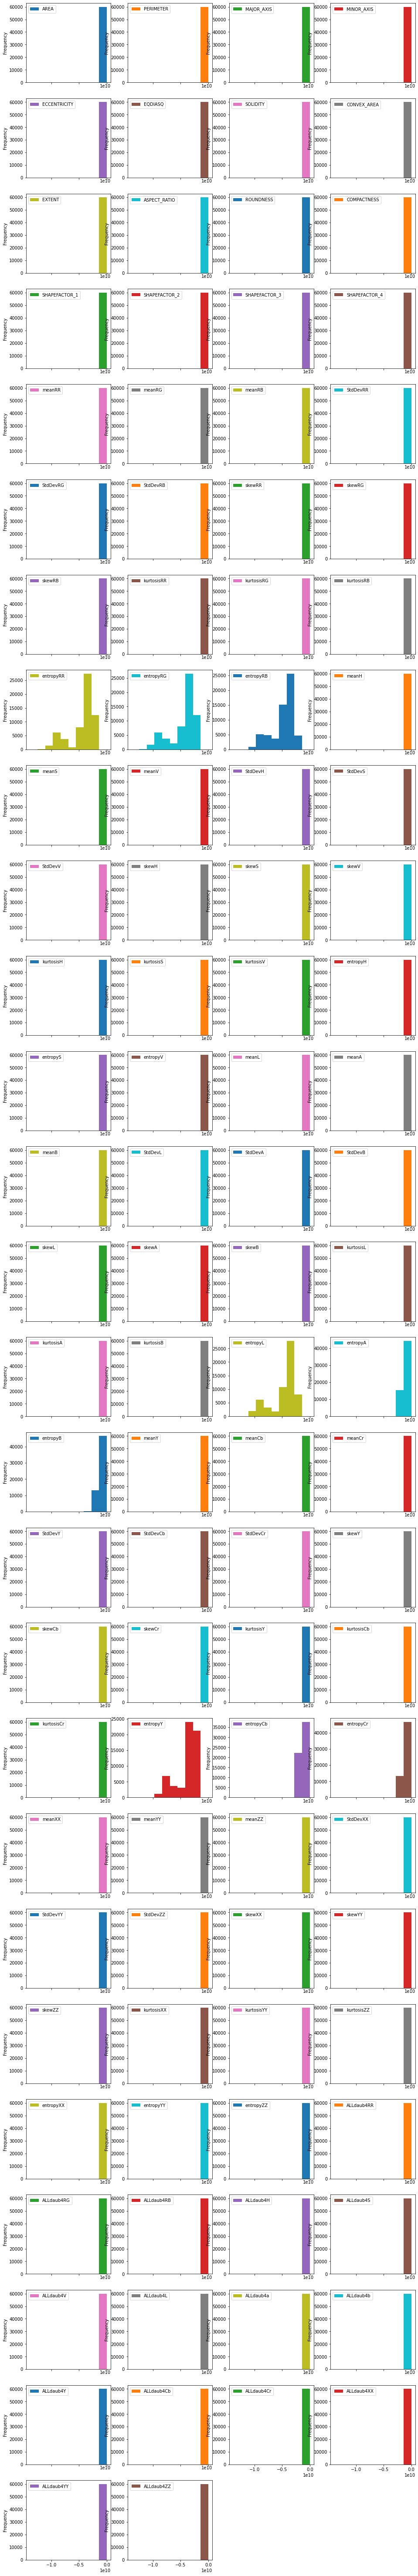

In [24]:
# Histograms for each attribute
df_features_train.plot(kind='hist', subplots=True, layout=(display_rows, display_columns))
plt.show()

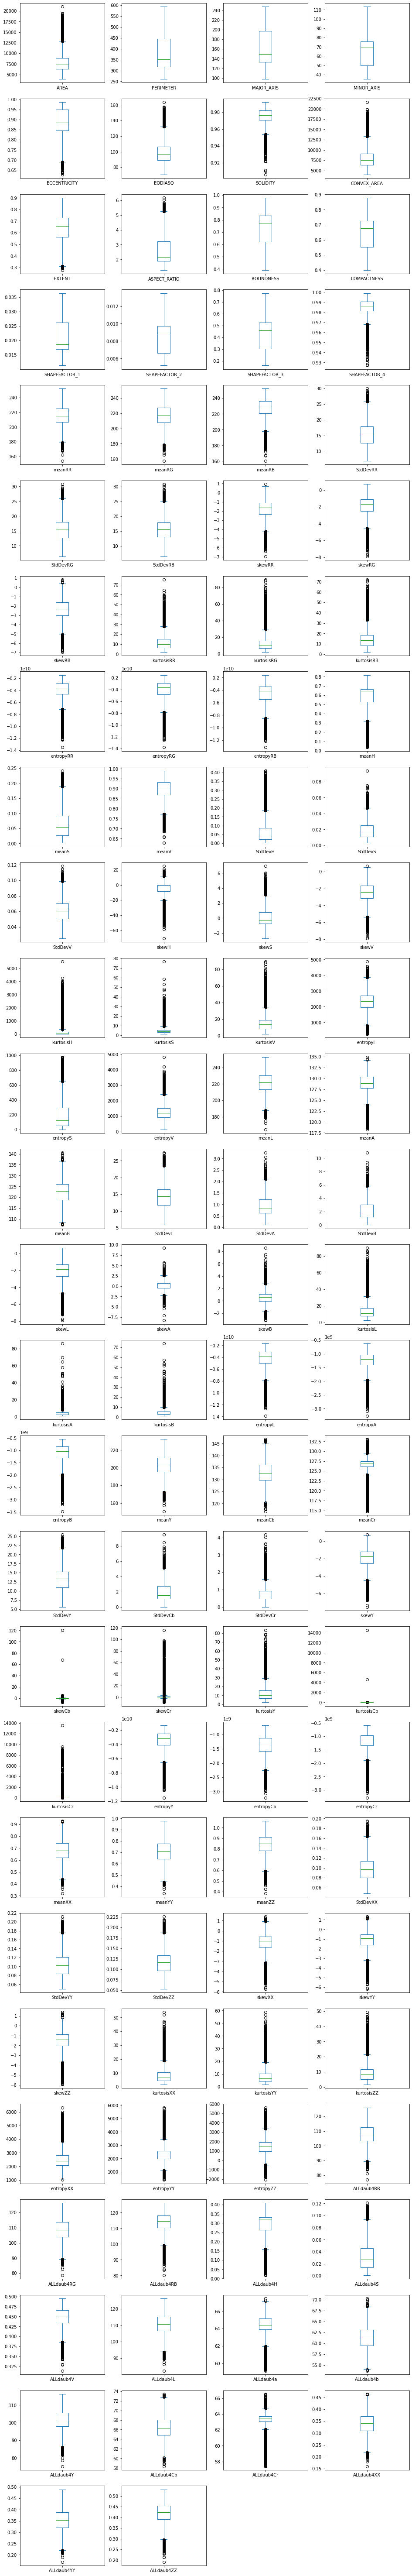

In [25]:
# Box and Whisker plot for each attribute
df_features_train.plot(kind='box', subplots=True, layout=(display_rows, display_columns))
plt.show()

In [26]:
# # Correlation matrix
# fig = plt.figure(figsize=(20, 20))
# correlations = df_features_train.corr(method='pearson')
# sns.heatmap(correlations, annot=True, cmap=plt.cm.PuBu)
# plt.show()

In [27]:
if NOTIFY_STATUS: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Train and Evaluate Models

In [28]:
if NOTIFY_STATUS: status_notify("Task 3 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Splitting Data into Training and Validation Sets

In [29]:
# Finalize the training and validation datasets for the modeling activities
tfds_train = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_train, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


### 3.b) Train and Evaluate the Random Forest Model

In [30]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
RF_model = tfdf.keras.RandomForestModel(task = tfdf.keras.Task.CLASSIFICATION)
RF_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     RF_model.fit(x=tfds_train)

# Train the model.
RF_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpwwjj5be8 as temporary training directory
Starting reading the dataset
60/60 [==============================] - ETA: 0s
Dataset read in 0:00:07.945998
Training model
Model trained in 0:00:15.870020
Compiling model


[INFO kernel.cc:1153] Loading model from path


60/60 [==============================] - 24s 342ms/step


[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model training time: 0:00:25.960708 



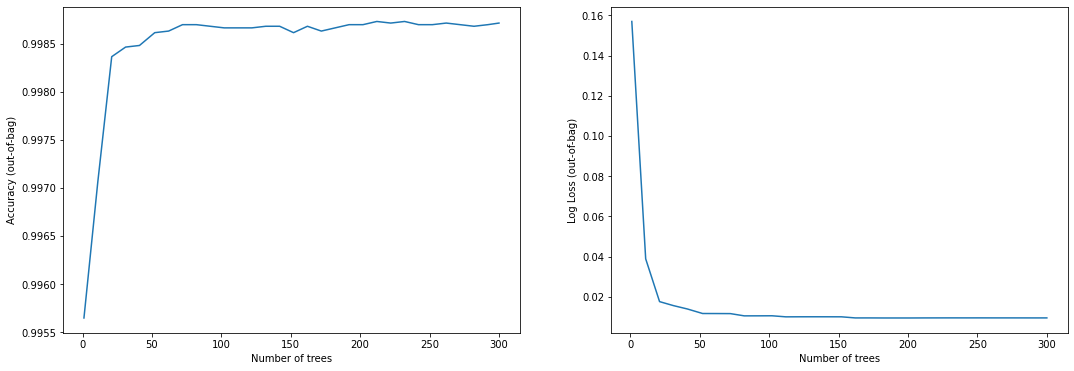

In [31]:
logs = RF_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [32]:
RF_eval = RF_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in RF_eval.items():
    print(f"{name}: {value:.4f}")

60/60 [==============================] - 5s 71ms/step - loss: 0.0000e+00 - accuracy: 0.9997 - sparse_categorical_crossentropy: 0.0033

loss: 0.0000
accuracy: 0.9997
sparse_categorical_crossentropy: 0.0033


### 3.c) Train and Evaluate the Decision Trees Model

In [33]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
CART_model = tfdf.keras.CartModel(task = tfdf.keras.Task.CLASSIFICATION)
CART_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     CART_model.fit(x=tfds_train)

# Train the model.
CART_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpa34ukdw5 as temporary training directory
Starting reading the dataset
60/60 [==============================] - ETA: 0s
Dataset read in 0:00:04.923834
Training model
Model trained in 0:00:00.666155
Compiling model
60/60 [==============================] - 6s 80ms/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "RandomForestGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Model training time: 0:00:06.428629 



In [34]:
CART_eval = CART_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in CART_eval.items():
    print(f"{name}: {value:.4f}")

60/60 [==============================] - 4s 68ms/step - loss: 0.0000e+00 - accuracy: 0.9966 - sparse_categorical_crossentropy: 0.0092

loss: 0.0000
accuracy: 0.9966
sparse_categorical_crossentropy: 0.0092


### 3.d) Train and Evaluate the Gradient Boosted Trees Model

In [35]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
GBT_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)
GBT_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     GBT_model.fit(x=tfds_train)

# Train the model.
GBT_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmpfchqqv2p as temporary training directory
Starting reading the dataset
60/60 [==============================] - ETA: 0s
Dataset read in 0:00:05.114886
Training model
Model trained in 0:02:07.724915
Compiling model
60/60 [==============================] - 133s 2s/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Model training time: 0:02:13.757469 



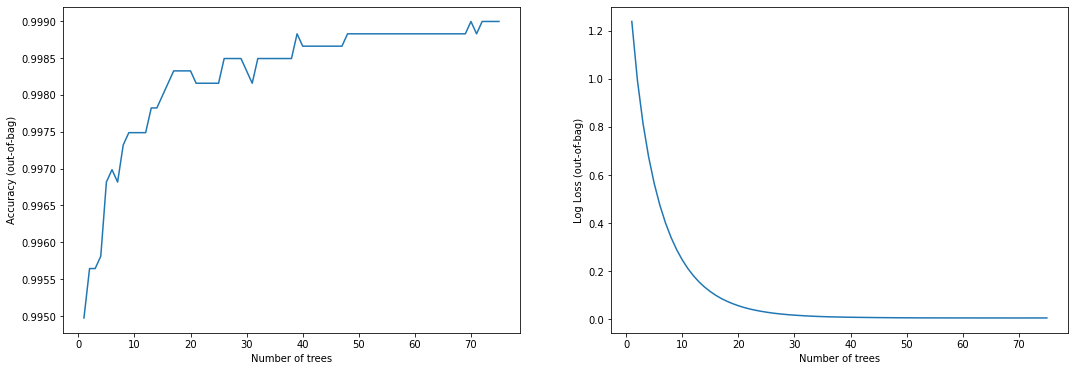

In [36]:
logs = GBT_model.make_inspector().training_logs()

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")
plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Log Loss (out-of-bag)")
plt.show()

In [37]:
GBT_eval = GBT_model.evaluate(tfds_train, return_dict=True)
print()

for name, value in GBT_eval.items():
    print(f"{name}: {value:.4f}")

60/60 [==============================] - 5s 69ms/step - loss: 0.0000e+00 - accuracy: 0.9999 - sparse_categorical_crossentropy: 0.0064

loss: 0.0000
accuracy: 0.9999
sparse_categorical_crossentropy: 0.0064


In [38]:
if NOTIFY_STATUS: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Fine-tune and Improve Models

In [39]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [40]:
# Not applicable for this iteration of modeling

In [41]:
if NOTIFY_STATUS: status_notify("Task 4 - Fine-tune and Improve Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [42]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 5.a) Train the Final Model

In [43]:
# Define the baseline model for benchmarking
start_time_module = datetime.now()
reset_random()
Final_model = tfdf.keras.GradientBoostedTreesModel(task = tfdf.keras.Task.CLASSIFICATION)

# Optionally, add evaluation metrics.
Final_model.compile(metrics=DEFAULT_METRICS)

# "sys_pipes" is optional. It enables the display of the training logs.
# with sys_pipes():
#     Final_model.fit(x=tfds_train)

# Train the model.
Final_model.fit(x=tfds_train)
print ('Model training time:', (datetime.now() - start_time_module), '\n')

Use /tmp/tmp9r48gfuj as temporary training directory
Starting reading the dataset
60/60 [==============================] - ETA: 0s
Dataset read in 0:00:05.005746
Training model
Model trained in 0:02:07.831318
Compiling model
60/60 [==============================] - 133s 2s/step


[INFO kernel.cc:1153] Loading model from path
[INFO abstract_model.cc:1063] Engine "GradientBoostedTreesGeneric" built
[INFO kernel.cc:1001] Use fast generic engine


Model training time: 0:02:13.746869 



In [44]:
Final_model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (106):
	ALLdaub4Cb
	ALLdaub4Cr
	ALLdaub4H
	ALLdaub4L
	ALLdaub4RB
	ALLdaub4RG
	ALLdaub4RR
	ALLdaub4S
	ALLdaub4V
	ALLdaub4XX
	ALLdaub4Y
	ALLdaub4YY
	ALLdaub4ZZ
	ALLdaub4a
	ALLdaub4b
	AREA
	ASPECT_RATIO
	COMPACTNESS
	CONVEX_AREA
	ECCENTRICITY
	EQDIASQ
	EXTENT
	MAJOR_AXIS
	MINOR_AXIS
	PERIMETER
	ROUNDNESS
	SHAPEFACTOR_1
	SHAPEFACTOR_2
	SHAPEFACTOR_3
	SHAPEFACTOR_4
	SOLIDITY
	StdDevA
	StdDevB
	StdDevCb
	StdDevCr
	StdDevH
	StdDevL
	StdDevRB
	StdDevRG
	StdDevRR
	StdDevS
	StdDevV
	StdDevXX
	StdDevY
	StdDevYY
	StdDevZZ
	entropyA
	entropyB
	entropyCb
	entropyCr
	entropyH
	entropyL
	entropyRB
	entropyRG
	entropyRR
	entro

### 5.b) Load Test Dataset and Make Predictions

In [45]:
# Finalize the test dataset for the prediction activities
tfds_test = tfdf.keras.pd_dataframe_to_tf_dataset(df_dataset_test, label='target', task = tfdf.keras.Task.CLASSIFICATION)

/usr/local/lib/python3.8/dist-packages/tensorflow_decision_forests/keras/core.py:2036: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features_dataframe = dataframe.drop(label, 1)


In [46]:
Final_eval = Final_model.evaluate(tfds_test, return_dict=True)
print()

for name, value in Final_eval.items():
    print(f"{name}: {value:.4f}")

15/15 [==============================] - 1s 71ms/step - loss: 0.0000e+00 - accuracy: 0.9988 - sparse_categorical_crossentropy: 0.0064

loss: 0.0000
accuracy: 0.9988
sparse_categorical_crossentropy: 0.0064


In [47]:
if NOTIFY_STATUS: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
print ('Total time for the script:',(datetime.now() - start_time_script))

Total time for the script: 0:05:43.186211
